# Model Training


### Feature Engineering

#### Steps 
* Exploring Features of the dataset
* Handling Missing Values
* Feature Engineering
* Feature Selection 

#### Import Packages and CSV

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("cleaned_hotel_booking.csv")

# Print shape of dataset
print(df.shape)

(119210, 31)


##  Data cleaning and Data Transformation

### Feature Extraction

* **Making new column named Total guests which is total visitors count**

* **By doing this we also reducing the number of attributes in a dataset while keeping as much of the variation in the original dataset as possible**

In [62]:
# Making single guests column which includes Children, Adult and Babies counts.
df["total_guests"]= df["children"]+df["adults"]+df["babies"]

In [63]:
# dropping Adult, Children and Babies 
df.drop(["babies","adults","children"],axis=1,inplace=True)

### Other Data Manipulations

* **Change the lead time from hours to days and rounding it off with 2 decimal points**

In [64]:
df["lead_time"]= (df["lead_time"]/24).round(2)

* **Manual encoding hotels type and months column**

In [65]:
df['hotel'] = df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})
df['arrival_date_month'] = df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
df['reserved_room_type'] = df['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'L': 8})

* **Replace and remove Undefined features**

In [66]:
# replace meal Undefined with Self Catering 
df["meal"].replace("Undefined", "SC", inplace=True)
# Replace 
df["market_segment"].replace("Undefined", "Online TA", inplace=True)
df.drop(df[df['distribution_channel'] == 'Undefined'].index, inplace=True, axis=0)

* **Based on the In-Sights from EDA, We Drop Columns which are not much impacting the target variable**

In [67]:
df.drop(columns=['arrival_date_week_number',"reservation_status","reservation_status_date",
                 "assigned_room_type",'agent','required_car_parking_spaces', 'is_repeated_guest'], inplace=True, axis=1)

### Types of Features 

* **Numerical Features**

In [68]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 16


* **Categorical Features**

In [69]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 6


* **Discrete Features**

In [70]:
discrete_feature=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_feature))

Num of Discrete Features : 10


In [71]:
year_features=[feature for feature in df.columns if 'date' in feature or 'month' in feature]
print('Num of Year Features :',len(year_features))

Num of Year Features : 3


* **Continues Features**

In [72]:
continuous_feature=[feature for feature in num_features if feature not in discrete_feature+year_features]
print('Num of Continuous Features :',len(continuous_feature))

Num of Continuous Features : 5


## Feature Selection

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [73]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [75]:
compute_vif(num_features, df)

,Variable,VIF
0,hotel,1.210034
1,is_canceled,1.213572
2,lead_time,1.272711
3,arrival_date_year,1.612115
4,arrival_date_month,1.546312
5,arrival_date_day_of_month,1.005525
6,stays_in_weekend_nights,1.345136
7,stays_in_week_nights,1.423576
8,previous_cancellations,1.067876
9,previous_bookings_not_canceled,1.054083


### Outlier Removal and Checking Skewness

* For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

* The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

* where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

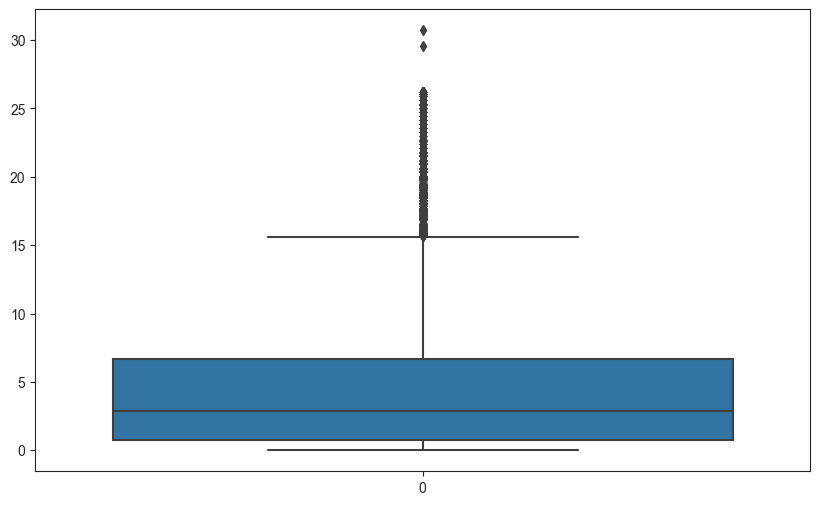

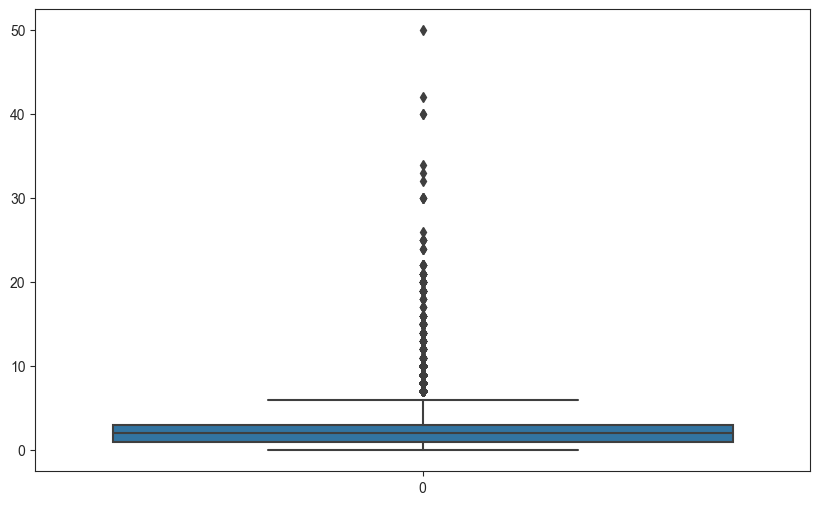

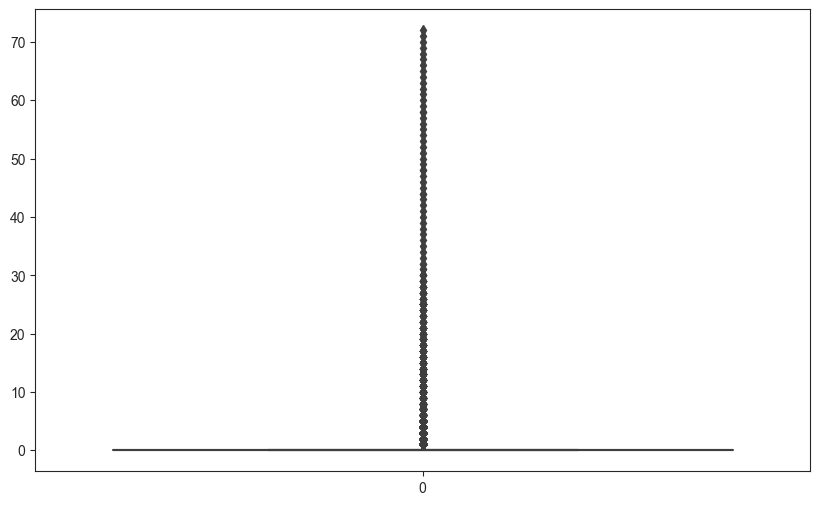

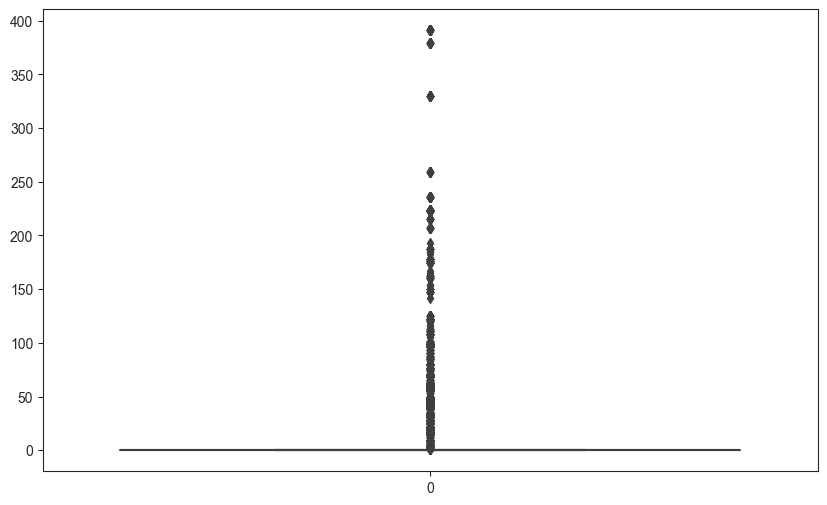

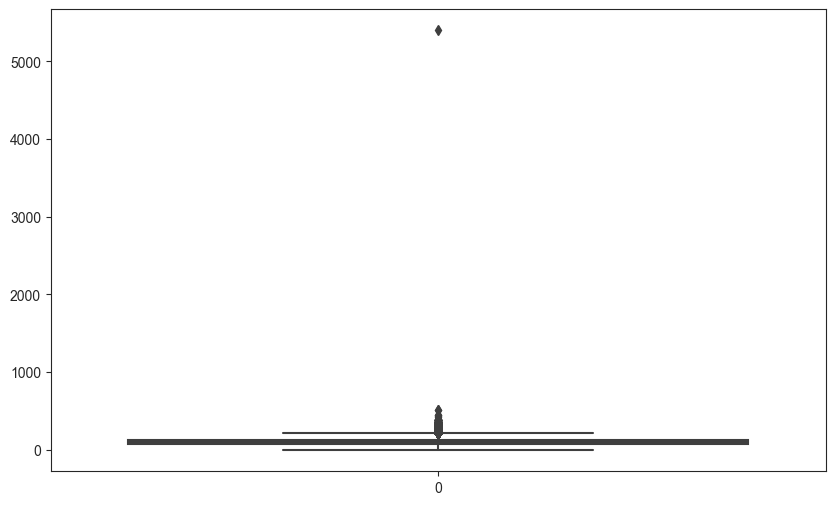

In [76]:
for i in continuous_feature:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [77]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

In [78]:
for col in continuous_feature:
         detect_outliers(col)


 #### lead_time ####
percentile25 0.75
percentile75 6.71
Upper limit 15.649999999999999
Lower limit -8.19

 #### stays_in_week_nights ####
percentile25 1.0
percentile75 3.0
Upper limit 6.0
Lower limit -2.0

 #### previous_bookings_not_canceled ####
percentile25 0.0
percentile75 0.0
Upper limit 0.0
Lower limit 0.0

 #### days_in_waiting_list ####
percentile25 0.0
percentile75 0.0
Upper limit 0.0
Lower limit 0.0

 #### adr ####
percentile25 69.5
percentile75 126.0
Upper limit 210.75
Lower limit -15.25


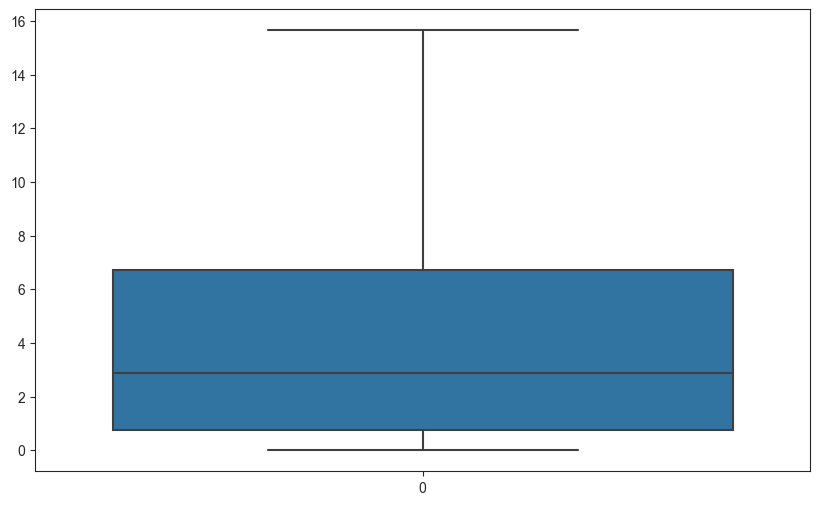

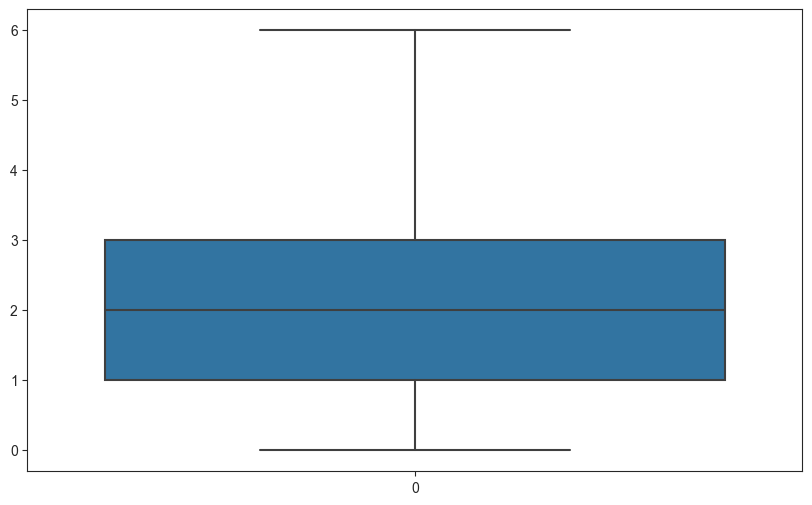

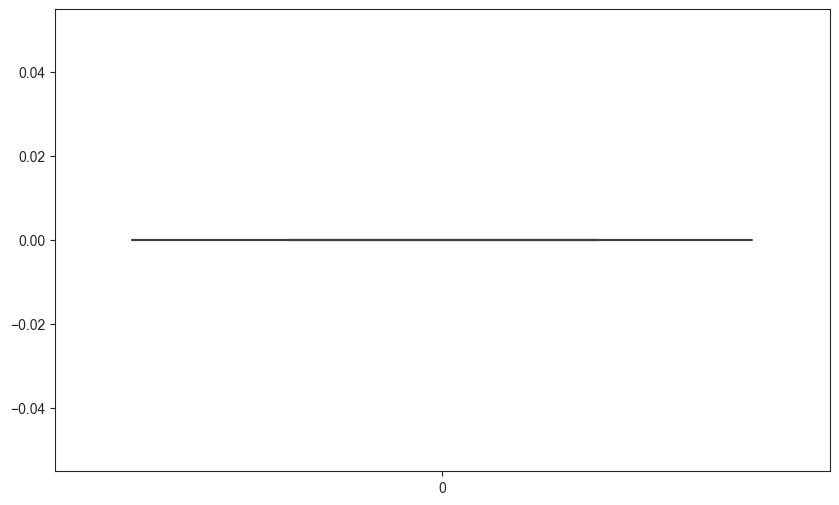

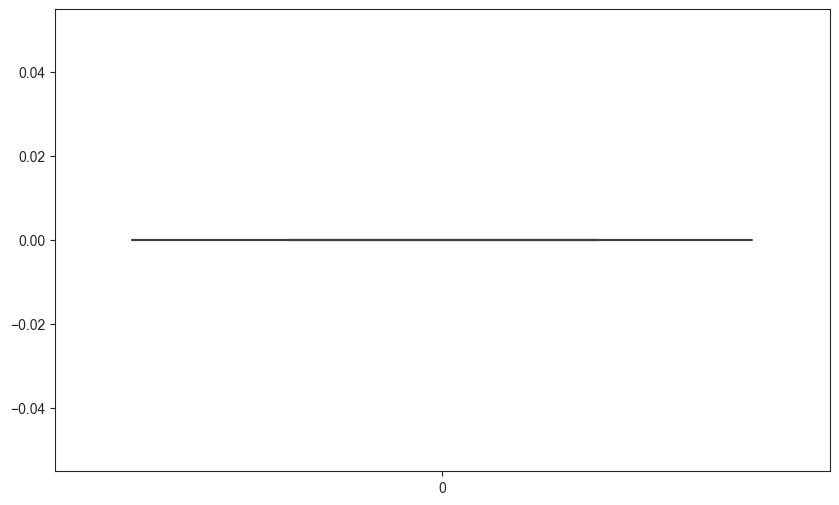

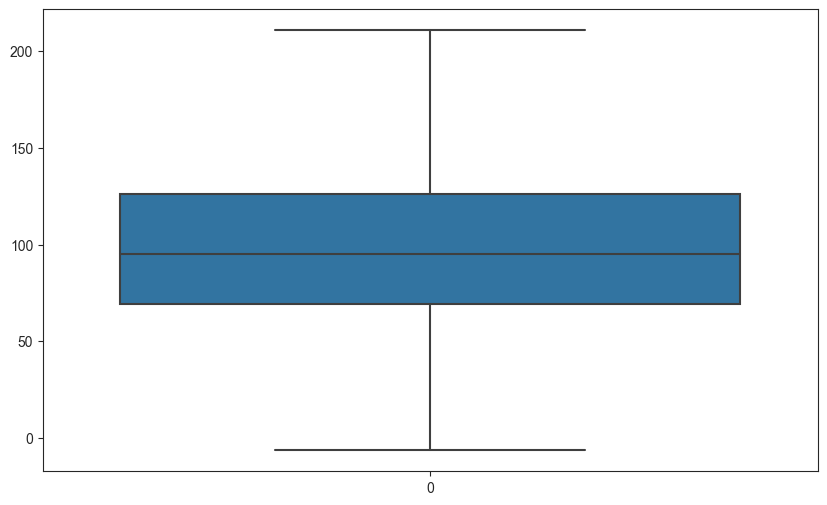

In [79]:
for i in continuous_feature:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [80]:
df.drop(['previous_bookings_not_canceled', 'days_in_waiting_list'], inplace=True, axis=1)

* **Check Distribution of Lead Time column**

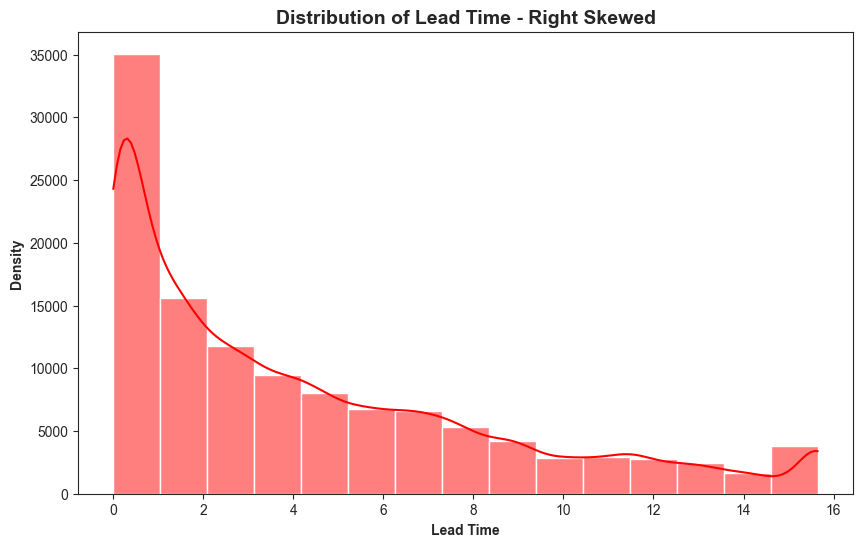

In [81]:
plt.figure(figsize=(10,6))
sns.set_style('ticks')
ax = sns.histplot(df['lead_time'],bins = 15,color = 'r',kde = True)
ax.set_title('Distribution of Lead Time - Right Skewed',fontsize = 14, weight='bold')
ax.set_xlabel("Lead Time",weight = 'bold')
ax.set_ylabel("Density",weight = 'bold');

In [82]:
df[['lead_time']] = df[['lead_time']].apply(np.log1p)

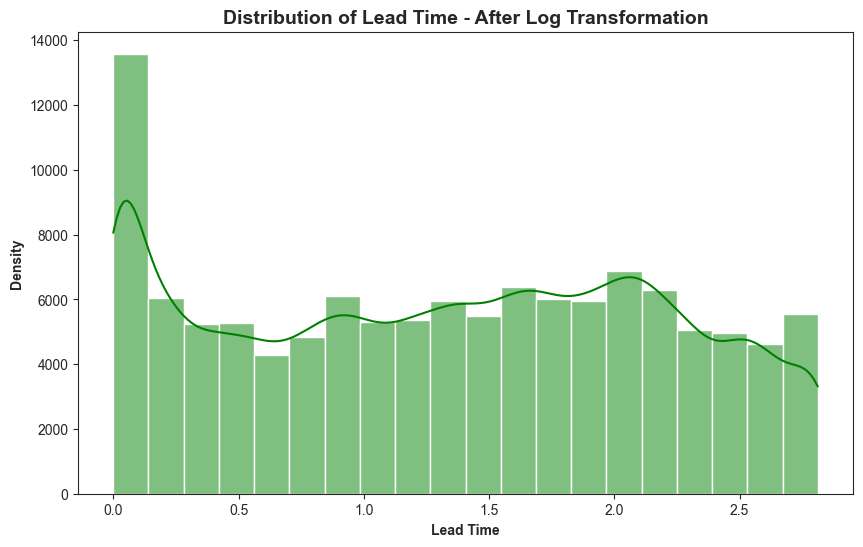

In [83]:
plt.figure(figsize=(10,6))
sns.set_style('ticks')
ax = sns.histplot(df['lead_time'],bins = 20,color = 'g', kde= True)
ax.set_title('Distribution of Lead Time - After Log Transformation',fontsize = 14, weight='bold')
ax.set_xlabel("Lead Time",weight = 'bold')
ax.set_ylabel("Density",weight = 'bold');

In [84]:
df.dropna(inplace=True)

### DataFrame Split

* **Split Dataframe to X and y**

* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “is_canceled” column.**

In [85]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
from sklearn.model_selection import train_test_split
X = df.drop(['is_canceled'], axis=1)
y = df['is_canceled']

* **Save the list of countries to use it in the app**

In [87]:
import pickle
countries = list(X.country.unique())
with open('countryname.pkl', 'wb') as handle:
    pickle.dump(countries, handle)

* **Check all columns which are in Train data set**

In [88]:
all_columns  = list(X.columns)
print(all_columns) 
len(all_columns)

['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'meal', 'country', 'market_segment', 'distribution_channel', 'previous_cancellations', 'reserved_room_type', 'booking_changes', 'deposit_type', 'customer_type', 'adr', 'total_of_special_requests', 'total_guests']


19

###  Feature Encoding

* **Extracting Categorical features from train set for feature encoding**

In [89]:
cat_features = [feature for feature in X.columns if X[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 6


* **Checking for Unique variables in each column**

In [90]:
for feature in cat_features:
    print(feature,':', X[feature].nunique())

meal : 4
country : 177
market_segment : 7
distribution_channel : 4
deposit_type : 3
customer_type : 4


## Pipeline for DataTransformation

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**

* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.


**Binary Encoder is used for Country which had 170 unique values**
* Binary encoding is a combination of Hash encoding and one-hot encoding. In this encoding scheme, the categorical feature is first converted into numerical using an ordinal encoder. Then the numbers are transformed in the binary number. After that binary value is split into different columns.

* Binary encoding works really well when there are a high number of categories, Like Countries in our case

In [91]:
# Create Column Transformer with 3 types of transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders.binary import BinaryEncoder
num_features = [feature for feature in X.columns if X[feature].dtype != 'O']
oh_columns = ['meal','market_segment','distribution_channel','deposit_type','customer_type']
bin_columns = ['country']

numeric_transformer = StandardScaler()
bin_transformer = BinaryEncoder()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
         ('binary' ,bin_transformer, bin_columns),
         ("oh", oh_transformer, oh_columns),
          ("num", numeric_transformer, num_features)
    ]
)

ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
# Apply Column Transformer
X = preprocessor.fit_transform(X)

NameError: name 'preprocessor' is not defined

In [ ]:
X

array([[ 0.        ,  0.        ,  0.        , ..., -2.26278444,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ..., -2.26278444,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ..., -0.57895841,
        -0.72076524, -1.35098757],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.27796495,
         4.32423173,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0811014 ,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ...,  1.13180885,
         1.80173324,  0.040073  ]])

In [ ]:
import pickle
pickle.dump(preprocessor, open('preprocess.pkl', 'wb'))

## Train Test Split

In [ ]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=36)
X_train.shape, X_test.shape

((89403, 43), (29802, 43))

## Model Selection

* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 0.9955
- F1 score: 0.9955
- Precision: 0.9947
- Recall: 0.9931
----------------------------------
Model performance for Test set
- Accuracy: 0.8788
- F1 score: 0.8773
- Precision: 0.8770
- Recall: 0.7876


Naive Bayes
Model performance for Training set
- Accuracy: 0.7771
- F1 score: 0.7582
- Precision: 0.8559
- Recall: 0.4765
----------------------------------
Model performance for Test set
- Accuracy: 0.7731
- F1 score: 0.7534
- Precision: 0.8624
- Recall: 0.4709


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8364
- F1 score: 0.8326
- Precision: 0.8370
- Recall: 0.6916
----------------------------------
Model performance for Test set
- Accuracy: 0.8346
- F1 score: 0.8307
- Precision: 0.8407
- Recall: 0.6905


Logistic Regression
Model performance for Training set
- Accuracy: 0.8028
- F1 score: 0.7964
- Precision: 0.8008
- Recall: 0.6202
----------------------------------
Model performance for Test set
-

### Hyper Parameter Tuning

In [ ]:
knn_params = {"n_neighbors": [2, 3, 10, 20, 40, 50]}

rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01],
              "max_depth": [5, 8, 12, 20, 30]}

In [ ]:
randomcv_models = [('KNN', KNeighborsClassifier(), knn_params),
                   ("RF", RandomForestClassifier(), rf_params),
                   ('XGBoost', XGBClassifier(), xgboost_params),
                   ('CatBoost', CatBoostClassifier(verbose=False), cat_params)
                   ]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    rf_random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    rf_random.fit(X_train, y_train)
    model_param[name] = rf_random. best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
---------------- Best Params for KNN -------------------
{'n_neighbors': 10}
---------------- Best Params for RF -------------------
{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 7, 'max_depth': None}
---------------- Best Params for XGBoost -------------------
{'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.4}
---------------- Best Params for CatBoost -------------------
{'max_depth': 12, 'learning_rate': 0.1}


### Models Re-Trained with Best Parameters

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, min_samples_split=2, max_features= 7, max_depth= None),
    "K-Neighbors Classifier": KNeighborsClassifier(n_neighbors=10),
    "XGBClassifier": XGBClassifier(n_estimators= 200, max_depth= 30, learning_rate= 0.1, colsample_bytree= 0.4, n_jobs=-1), 
    "CatBoosting Classifier": CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False),
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc



    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 0.9955
- F1 score: 0.9955
- Precision: 0.9947
- Recall: 0.9931
- Roc Auc Score: 0.9950
----------------------------------
Model performance for Test set
- Accuracy: 0.8796
- F1 score: 0.8782
- Precision: 0.8761
- Recall: 0.7913
- Roc Auc Score: 0.8620


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.8648
- F1 score: 0.8618
- Precision: 0.8788
- Recall: 0.7350
- Roc Auc Score: 0.8379
----------------------------------
Model performance for Test set
- Accuracy: 0.8354
- F1 score: 0.8317
- Precision: 0.8398
- Recall: 0.6943
- Roc Auc Score: 0.8073


XGBClassifier
Model performance for Training set
- Accuracy: 0.9954
- F1 score: 0.9954
- Precision: 0.9946
- Recall: 0.9929
- Roc Auc Score: 0.9949
----------------------------------
Model performance for Test set
- Accuracy: 0.8786
- F1 score: 0.8772
- Precision: 0.8759
- Recall: 0.7886
- Roc Auc Score: 0.8607


CatBoosting Classifier
Model performance for T

### Plot ROC-AUC curve

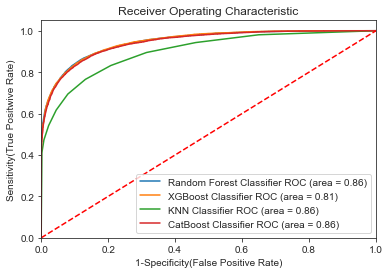

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(n_estimators=1000, min_samples_split=2, max_features= 'auto', max_depth= None),
    'auc': 0.8618
},
{
    'label': 'XGBoost Classifier',
    'model': XGBClassifier(n_estimators= 200, max_depth= 20, learning_rate= 0.1, colsample_bytree= 0.8, n_jobs=-1),
    'auc': 0.8073
},
{
    'label': 'KNN Classifier',
    'model': KNeighborsClassifier(n_neighbors=10),
    'auc': 0.8629 
},
{
    'label': 'CatBoost Classifier',
    'model': CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False),
    'auc': 0.8615
},
    
]

# Below for loop iterates through your models list
for m in auc_models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], m['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positwive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(r"./images/roc_auc/auc.png")
plt.show()   # Display

### Feature Selection for Model Deployment

In [ ]:
best_xgb = XGBClassifier(n_estimators= 200, max_depth= 30, learning_rate= 0.1, colsample_bytree= 0.4, n_jobs=-1)
best_xgb = best_xgb.fit(X_train,y_train)
xgb_pred = best_xgb.predict(X_test)
score = accuracy_score(y_test,xgb_pred)
cr = classification_report(y_test,xgb_pred)

print("FINAL XGB")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL XGB
Accuracy Score value: 0.8786
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     18609
           1       0.88      0.79      0.83     11193

    accuracy                           0.88     29802
   macro avg       0.88      0.86      0.87     29802
weighted avg       0.88      0.88      0.88     29802



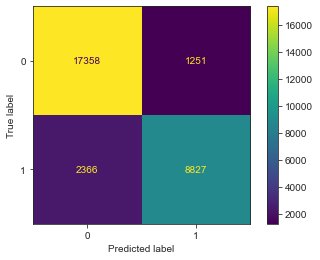

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)

In [39]:
import pickle
 
# Save the trained model as a pickle file.
pickle.dump(best_xgb, open('classificationmodel.pkl', 'wb'))